### Загрузка данных

In [1]:
import yfinance as yf

def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-22')
    return tickerDf.iloc[:, :5]

apple_df = get_price_data('AAPL')
apple_df = apple_df.drop(columns = ['Open','High', 'Low', 'Volume'])
apple_df.head()

,Close
Date,
2017-01-03 00:00:00-05:00,27.219831
2017-01-04 00:00:00-05:00,27.189365
2017-01-05 00:00:00-05:00,27.327639
2017-01-06 00:00:00-05:00,27.632294
2017-01-09 00:00:00-05:00,27.885389


Так как данные ежедневные, временной ряд имеет большие колебания и некоторые выбросы. Можно перейти к недельному интервалу, чтобы сгладить ряд и лучше видеть тренд.

In [2]:
apple_df = apple_df.resample('W').mean()

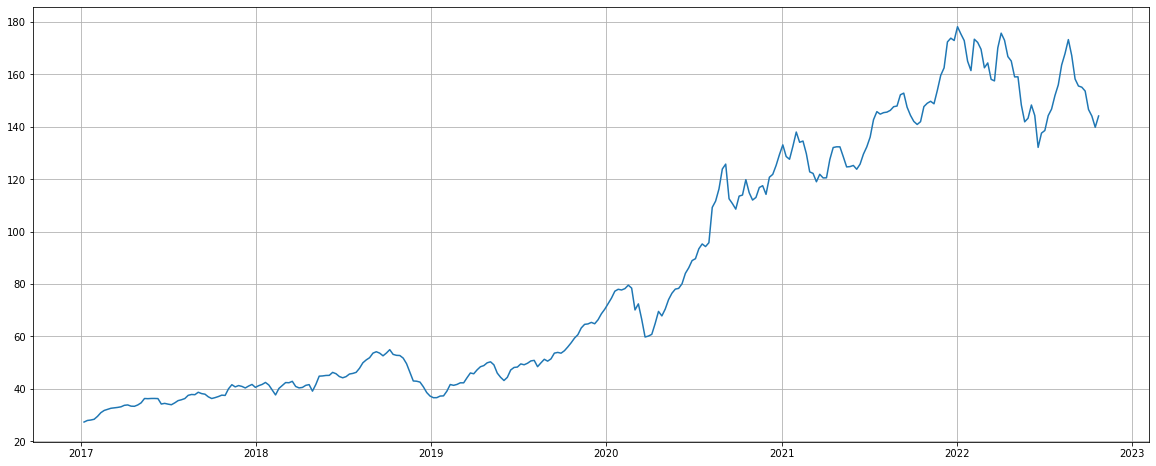

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(apple_df['Close'], linewidth=1.5)
plt.grid(True)
plt.show()

In [4]:
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
import statsmodels as sm
import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import numpy as np

warnings.filterwarnings('ignore')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Проверим исходный ряд на стационарность. Стационарные ряды легче прогнозировать, так как будущие статистические характеристики не будут отличаться от наблюдаемых текущих.

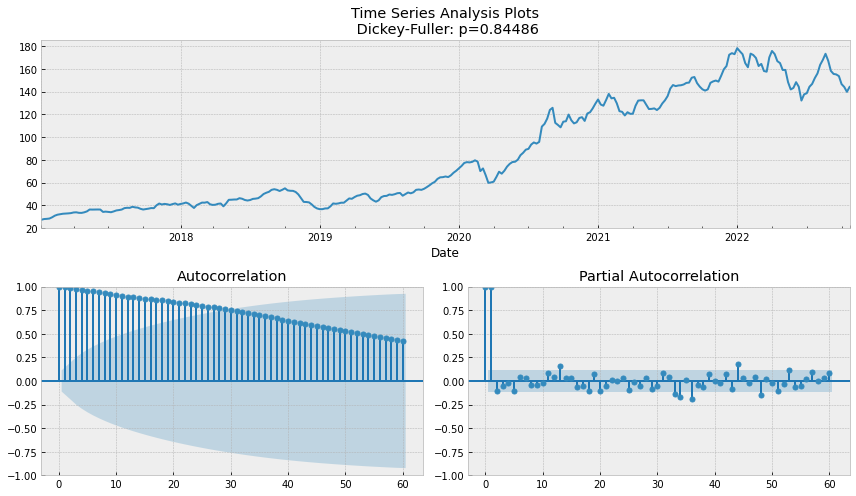

In [5]:
tsplot(apple_df.Close, lags=60)

Путем сдвига ряда первым разностями получили стационарный ряд, таким образом, изначальный ряд является интегрированным первого порядка.

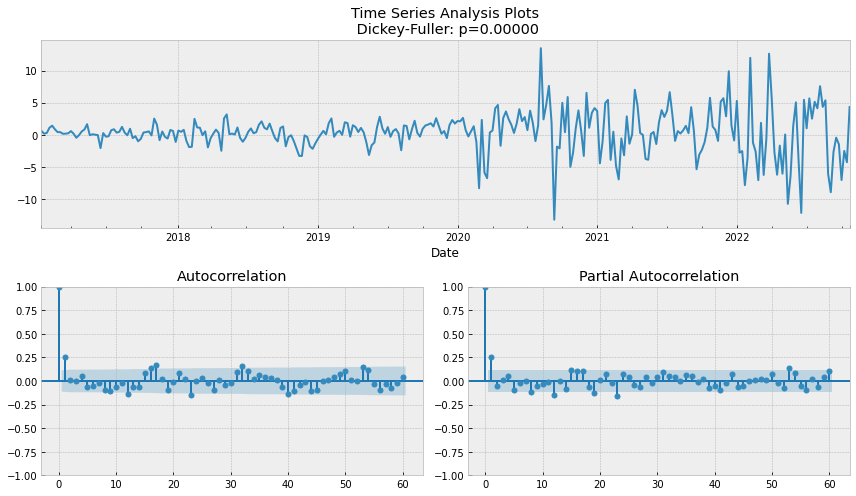

In [6]:
ts_diff = apple_df.Close - apple_df.Close.shift(1)
tsplot(ts_diff[1:], lags=60)

Так как первым порядком интегрирования получили стационарный ряд, параметры d и D равны 1. Остальные параметры будут перебираться по сетке.

In [7]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)
s = 24 

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

Проведем перебор параметров с оптимизацией по метрике AIC

In [8]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.sarimax.SARIMAX(data, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Разделим временной ряд на обучающую и тестовую выборки

In [9]:
len_test = 20 
train = apple_df[:-len_test]
test = apple_df[-len_test:]

In [10]:
%%time
result_table = optimizeSARIMA(train, parameters_list, d, D, s)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: total: 1h 58min 52s
Wall time: 30min 29s


In [11]:
result_table.head()

,parameters,aic
0,"(4, 2, 4, 0)",1350.484578
1,"(4, 2, 3, 0)",1351.076192
2,"(4, 3, 4, 0)",1353.916714
3,"(4, 3, 3, 0)",1354.625096
4,"(0, 1, 4, 0)",1355.275802


Модель SARIMA на лучших параметрах

In [12]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.sarimax.SARIMAX(train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  283
Model:             SARIMAX(4, 1, 2)x(4, 1, [], 24)   Log Likelihood                -664.242
Date:                             Tue, 25 Oct 2022   AIC                           1350.485
Time:                                     14:47:47   BIC                           1389.567
Sample:                                 01-08-2017   HQIC                          1366.200
                                      - 06-05-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0358      0.069     -0.515      0.607      -0.172       0.100
ar.L2         -0.9473      

Прогноз на длину тестовой выборки

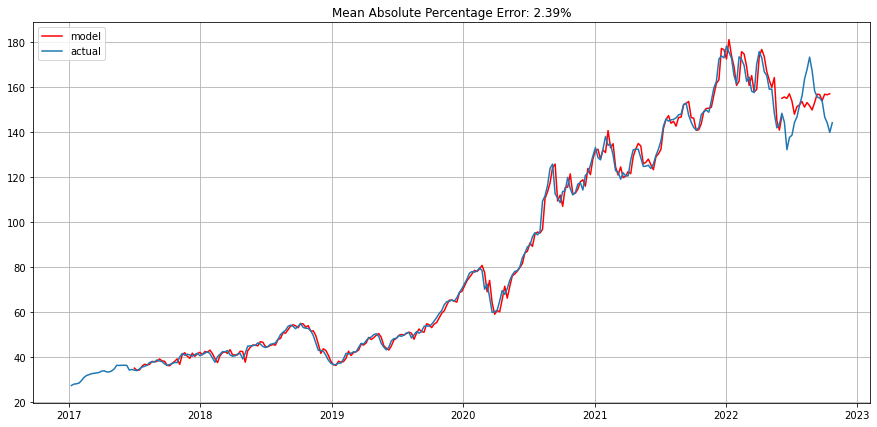

In [13]:
def plotSARIMA(ts, model, n_steps, s=24, d=1):
    data = ts.copy()
    data['arima_model'] = best_model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = model.get_forecast(steps = n_steps)
    prediction_values = forecast.predicted_mean.values

    start_date = str(model.fittedvalues.index[-1])[:10]
    d_range = pd.date_range(start = start_date, periods = n_steps, freq = 'W')
    forecast_series = pd.Series(prediction_values, index = d_range)

    error = mean_absolute_percentage_error(data['Close'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(data.arima_model, color='r', label="model")
    plt.plot(forecast_series, color='r')
    plt.plot(data.Close, label="actual")

    plt.legend()
    plt.grid(True);
    
plotSARIMA(apple_df, best_model, len_test)

Для оценки качества прогноза SARIMA выбрана метрика MAPE. Она хорошо интерпретируема и показывает на сколько в процентах ошибается модель. При прогнозе модели на следующий шаг модель показывает отличное качество, ошибка составляет всего 2.39 процента. Для оценки прогноза на более длительный период, чем следующий шаг, была отложена валидационная выборка. Как видно, построить качественный прогноз на 20 недель не получилось. Возрастающий тренд не был зафиксирован, модель спрогнозировала средние значения на дистанции.

Проведем обучение модели на всей длине временного ряда и построим прогноз на следующий год. Через время проверим, была ли наша модель хороша :)

In [14]:
best_model = sm.tsa.statespace.sarimax.SARIMAX(apple_df, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  303
Model:             SARIMAX(4, 1, 2)x(4, 1, [], 24)   Log Likelihood                -734.825
Date:                             Tue, 25 Oct 2022   AIC                           1491.651
Time:                                     14:50:13   BIC                           1531.554
Sample:                                 01-08-2017   HQIC                          1507.660
                                      - 10-23-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0174      0.061     -0.285      0.775      -0.137       0.102
ar.L2         -0.9176      

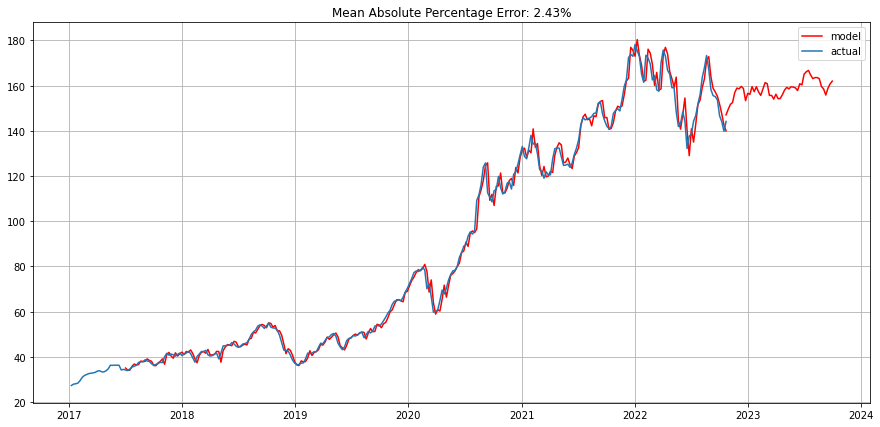

In [15]:
plotSARIMA(apple_df, best_model, 50)